In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [424]:
# use Brandon Rhodes' DataFrame style
#  https://github.com/brandon-rhodes/pycon-pandas-tutorial/blob/master/style-table.css
from IPython.core.display import HTML
css = open('style-table.css').read()
HTML('<style>{}</style>'.format(css))

In [ ]:
df = pd.read_csv('bigframe.csv')

In [122]:
print(df.shape)
df.head()

(1425447, 28)


,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,brewery_id,brewery_type,brewery_country,...,venue_state,venue_cat,venue_id,checkin_comment,venue_type,rating_global,beer_description,abv,date,ipa
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,1204,Regional Brewery,United States,...,NaN,NaN,NaN,"Easy-drinking, not too hoppy. Solid.",[],3.73789,To create a recipe so tropical and fruity with...,7.5,2019-10-26 03:52:50+00:00,True
1,818949121,1709568,3340203,3.50,Ritual Brewing Company,Pale Ale,Pale Ale - American,39329,Micro Brewery,United States,...,CA,Nightlife Spot,376422.0,Solid.,['brewery'],3.43165,NaN,5.2,2019-10-19 03:07:43+00:00,False
2,818856642,2734572,3340203,4.25,Ritual Brewing Company,Oil Rig,IPA - Imperial / Double,39329,Micro Brewery,United States,...,CA,Nightlife Spot,376422.0,Gooood stuff. Cool place too.,['brewery'],3.87873,NEW TRADITIONS CALL FOR NEW HOLIDAYS AND NEW H...,9.0,2019-10-19 00:37:37+00:00,True
3,815159720,1044097,3340203,4.25,Stone Brewing,Stone Ruination Double IPA 2.0,IPA - Imperial / Double,1204,Regional Brewery,United States,...,NaN,NaN,NaN,Probably the best Stone beer I’ve had. I’m a fan.,[],4.01290,Stone Ruination IPA was the first full-time br...,8.5,2019-10-10 02:20:55+00:00,True
4,814916483,1070,3340203,3.75,Lagunitas Brewing Company,Imperial Stout,Stout - Russian Imperial,765,Macro Brewery,United States,...,NaN,NaN,NaN,"A really nice, if unspectacular, stout.",[],3.91420,"Made with Highly roasted malted barley, and pl...",9.9,2019-10-09 04:25:53+00:00,False


In [237]:
df.date[:5]

0    2019-10-26 03:52:50+00:00
1    2019-10-19 03:07:43+00:00
2    2019-10-19 00:37:37+00:00
3    2019-10-10 02:20:55+00:00
4    2019-10-09 04:25:53+00:00
Name: date, dtype: object

In [238]:
# pd.to_csv changes datetimes back to strings, so this has to be converted back to datetimes now

df['date'] = pd.to_datetime(df.date)
df.date[:5]

0   2019-10-26 03:52:50+00:00
1   2019-10-19 03:07:43+00:00
2   2019-10-19 00:37:37+00:00
3   2019-10-10 02:20:55+00:00
4   2019-10-09 04:25:53+00:00
Name: date, dtype: datetime64[ns, UTC]

=====================================================================================================================

Each line in these dataframes represents a single check-in by a user of the Untappd app, where the user left a rating for the beer.

The main focus of this project is predicting ratings specifically for IPA's, as opposed to the dozens of other styles of beer.  To that end, and despite the memory it will use, it will be worth splitting the dataframe into two subframes at the start of analysis.

IPA's vs non-IPA's

In [26]:
df['ipa'] = df.beer_style.str.startswith('IPA')
# don't necessarily need that boolean column to be part of the frame, but it may be useful later
ipas = df[df.ipa]
non_ipas = df[df.ipa == False]

## This first part of the notebook explores the basic counts and distributions of the beers, users, and checkins.  The second part will focus on the ratings.

In [222]:
print(f"Number of IPA's reviewed: {len(ipas)}")
print(f"Number of unique IPA's: {ipas.beer_id.nunique()}")
print()
print(f'Number of other beers: {len(non_ipas)}')
print(f'Number of unique other beers: {non_ipas.beer_id.nunique()}')

Number of IPA's reviewed: 688887
Number of unique IPA's: 84894

Number of other beers: 736560
Number of unique other beers: 179749


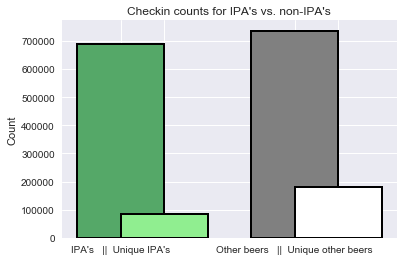

In [409]:
_ = plt.bar([1,2,5,6], [len(ipas), ipas.beer_id.nunique(),
                    len(non_ipas), non_ipas.beer_id.nunique()], 
        width=2, color=['C1', 'lightgreen', 'gray', 'white'],
        tick_label=["IPA's   ||  Unique IPA's", "", 'Other beers   ||  Unique other beers', ""],
        linewidth=2, edgecolor='k')

_ = plt.ylabel('Count')
_ = plt.title("Checkin counts for IPA's vs. non-IPA's")


#### The number of checkins is about the same for IPA's vs. non-IPA's, but the IPA checkins are much more concentrated on a smaller number of unique beers. 

Distribution of the number of ratings each user has in this dataset:

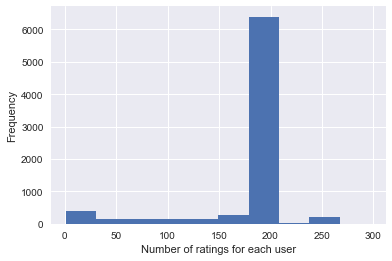

In [261]:
df.groupby('user_id').size().plot(kind='hist');
plt.xlabel('Number of ratings for each user');

Determining the best way to analyze and predict user ratings will in part depend on how sparse the ratings are.  I.e., how many users in this dataset rated each beer?

In [135]:
n_users = df.user_id.nunique()
n_beers = df.beer_id.nunique()
print(f'Number of reviewers in this set of 1.4 million reviews: {n_users}')
print(f'Number of beers reviewed in those 1.4 million reviews:  {n_beers}')
print(f'Beer-to-User ratio:  {np.round(n_beers / n_users, 3)}')
print(f'Avg. number of beers reviewed by each user: \
{np.round(df.groupby(df.user_id).size().mean(), 3)}')

Number of reviewers in this set of 1.4 million reviews: 7907
Number of beers reviewed in those 1.4 million reviews:  264620
Beer-to-User ratio:  33.467
Avg. number of beers reviewed by each user: 180.277


In [230]:
print(f'The ratio between the last 2 ratios shows that the average number of times any one \
beer was reviewed was {np.round(180.277 / 33.467, 3)}')

The ratio between the last 2 ratios shows that the average number of times any one beer was reviewed was 5.387


#### Another way of seeing that is to look at the previous bar chart, where we can see that for IPA's (the green bars), there are about 8 checkins for each unique beer, whereas for other styles (in blue) the ratio is about 4 checkins per unique beer.

So on the one hand, this describes an extremely sparse User x Beer matrix of ratings, but at least it is denser for the IPA ratings.
Let's see how that ratio is distributed.  Maybe the ratio holds somewhat even, and every beer has at least a few ratings.  Or maybe there's a small group of very popular/commonly available beers that get most of the ratings, and many more that are only rated once or twice.

In [174]:
counts = df.groupby(df.beer_id).size().sort_values(ascending=False)

print(f'The max number of reviews for any one beer is {counts.iloc[0]}')
print(f'The median number is {counts.iloc[len(counts) // 2]}')

The max number of reviews for any one beer is 2412
The median number is 2


#### This shows an extremely uneven, exponential distribution of ratings, with the max 1200 times higher than the median.  Attempts to use collaborative filtering to predict ratings are likely to rely very much on how users rated a small group of beers.

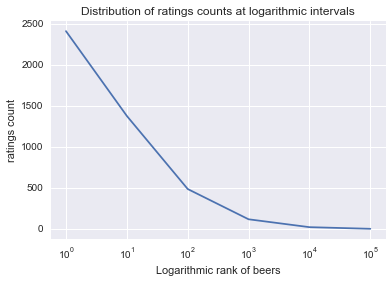

In [187]:
plt.plot([10**p for p in range(6)],[counts.iloc[10**p-1] for p in range(6)])
plt.xscale('log')
plt.title('Distribution of ratings counts at logarithmic intervals')
plt.xlabel('Logarithmic rank of beers')
plt.ylabel('ratings count');

In [259]:
for power in range(6):
    print(f'Beer {10**power}:')
    print(f'   {counts.iloc[10**power-1]} ratings')
print(f'Beers with just 1 rating:  {counts.value_counts().loc[1]}')

Beer 1:
   2412 ratings
Beer 10:
   1378 ratings
Beer 100:
   487 ratings
Beer 1000:
   118 ratings
Beer 10000:
   22 ratings
Beer 100000:
   2 ratings
Beers with just 1 rating:  123345


As far as where these beers are being rated and brewed:

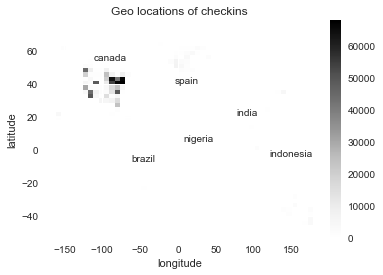

In [226]:
geos = df.dropna(subset=['venue_lat','venue_lon'])

_ = plt.hist2d(geos.venue_lon, geos.venue_lat, bins=50)
_ = plt.xlabel('longitude')
_ = plt.ylabel('latitude')
_ = plt.text(x=-5, y=40, s='spain')
_ = plt.text(x=-61, y=-7, s='brazil')
_ = plt.text(x=77, y=21, s='india')
_ = plt.text(x=7, y=5, s='nigeria')
_ = plt.text(x=-111, y=54, s='canada')
_ = plt.text(x=121, y=-4, s='indonesia')
_ = plt.title('Geo locations of checkins')
_ = plt.colorbar()

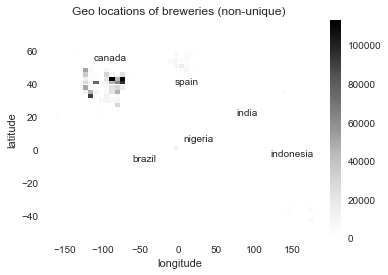

In [228]:
geos = df.dropna(subset=['brewery_lat','brewery_lon'])

_ = plt.hist2d(geos.brewery_lon, geos.brewery_lat, bins=50)
_ = plt.xlabel('longitude')
_ = plt.ylabel('latitude')
_ = plt.text(x=-5, y=40, s='spain')
_ = plt.text(x=-61, y=-7, s='brazil')
_ = plt.text(x=77, y=21, s='india')
_ = plt.text(x=7, y=5, s='nigeria')
_ = plt.text(x=-111, y=54, s='canada')
_ = plt.text(x=121, y=-4, s='indonesia')
_ = plt.title('Geo locations of breweries (non-unique)')
_ = plt.colorbar()

#### As expected, the bulk of the checkins are for breweries located in the NE of the U.S. and along its West Coast.  A secondary grouping of breweries lies in the U.K. and NW Europe, with a smaller cluster in SE Australia and New Zealand, plus one area in West Africa and another in Japan.  The checkin venues themselves (the upper of the two plots) are similarly distributed, although the people rating the West African beers are not doing so from that part of the world.

Perhaps the checkin (user) locations have been trending some direction over time?

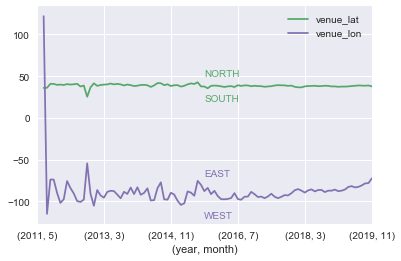

In [242]:
yrmo = df.groupby([df.date.dt.year, df.date.dt.month])

yrmo.venue_lat.mean().plot(color='C1')
yrmo.venue_lon.mean().plot(color='C3')
plt.legend()
plt.xlabel('(year, month)')
plt.text(s='NORTH', color='C1', x=50,y=50)
plt.text(s='SOUTH', color='C1', x=50,y=20)
plt.text(s='EAST', color='C3', x=50,y=-70)
plt.text(s='WEST', color='C3', x=50,y=-120);

#### The mean latitude of checkin venues has stayed very steady over the years, but the longitude has shifted significantly to the east in the last 2-3 years.

Having brought time into the equation, let's see if we can determine from this sample of 8K users how the flow of action for Untappd has evolved over time, i.e. how does growth look?  Since the checkins were pulled into this dataset by using Untappd's API, the data were retrieved in order of most recent checkins for each user.  That makes it impossible to use checkin counts to determine growth rate for the app.  But fortunately Untappd enumerates and indexes their checkins chronologically with the `checkin_id`, so we can use those as y-values and the checkin dates as x-values, to get a pretty accurate picture of Untappd's growth.

In [246]:
# set index to dates to be able to sort them and work with them faster
dated = df.set_index('date').sort_index()

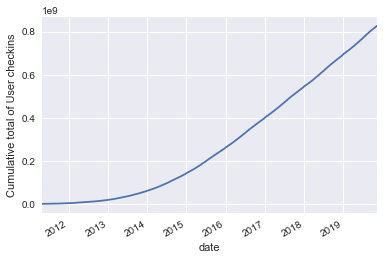

In [245]:
# This is a proxy for the flow of all checkins.  The rate of change of the slope is growth.
dated.checkin_id.plot()
plt.ylabel('Cumulative total of User checkins');

#### It looks like it was growing fastest 2013-2015 and has tapered off since then, but is slowly growing still. 
#### Their billionth checkin should come in about a year.


Let's take a more detailed look at those same growth data.

In [247]:
# we'll take 13-week intervals and see the mean checkin_id for that quarter, then compare
## the quarter-on-quarter changes and see when they're growing fastest and slowest (a.k.a. growth)
dates = pd.date_range(start=dated.index[0], periods=35, freq='91D').normalize()  # remove the clock time
dates

DatetimeIndex(['2011-05-01 00:00:00+00:00', '2011-07-31 00:00:00+00:00',
               '2011-10-30 00:00:00+00:00', '2012-01-29 00:00:00+00:00',
               '2012-04-29 00:00:00+00:00', '2012-07-29 00:00:00+00:00',
               '2012-10-28 00:00:00+00:00', '2013-01-27 00:00:00+00:00',
               '2013-04-28 00:00:00+00:00', '2013-07-28 00:00:00+00:00',
               '2013-10-27 00:00:00+00:00', '2014-01-26 00:00:00+00:00',
               '2014-04-27 00:00:00+00:00', '2014-07-27 00:00:00+00:00',
               '2014-10-26 00:00:00+00:00', '2015-01-25 00:00:00+00:00',
               '2015-04-26 00:00:00+00:00', '2015-07-26 00:00:00+00:00',
               '2015-10-25 00:00:00+00:00', '2016-01-24 00:00:00+00:00',
               '2016-04-24 00:00:00+00:00', '2016-07-24 00:00:00+00:00',
               '2016-10-23 00:00:00+00:00', '2017-01-22 00:00:00+00:00',
               '2017-04-23 00:00:00+00:00', '2017-07-23 00:00:00+00:00',
               '2017-10-22 00:00:00+00:00', '2018-0

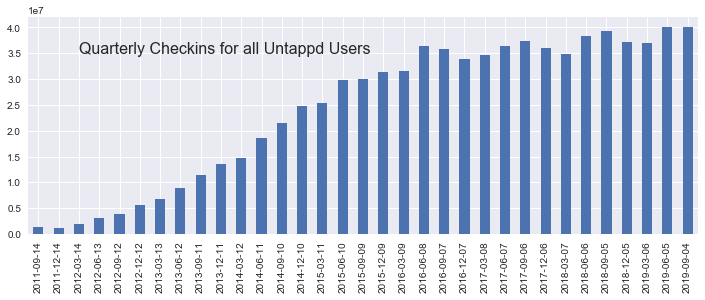

In [292]:
# This sets all times to midnight, for comparisons
dated = dated.set_index(dated.index.normalize())

# Use those quarterly dates to make a column of date bins to be able to group by them
dated['datebin'] = pd.cut(dated.index, dates)

# this makes a Series whose index is the date bins
means = dated.groupby('datebin')['checkin_id'].mean()

# Now make a column of quarterly diffs, and use the bin (index) midpoints as xticks
diffs = pd.Series([int(means[i]-means[i-1]) for i in range(1,len(means))], 
                  index=[i.mid.date() for i in means.index[1:]])
diffs.plot(kind='bar', figsize=(12,4))
plt.text(x=2, y=3.5e7, s='Quarterly Checkins for all Untappd Users', fontsize=16)
plt.show()

#### As expected, checkin growth was fastest in 2013-2015, and while the app has seen consecutive quarters of falling usage numbers 3 times since then, the overall trend is still upwards.  From June of 2015 to June of 2019 (4 years) the quarterly checkins went up by a million.  By comparison, in the 1 year from June of 2014 to June of 2015, the quarterly checkins went up more than that.  

What about for IPA's?  They seem to have followed a similar trajectory of popularity.  Let's see what percentage of checkins they've accounted for over this timeframe.

In [253]:
all_checkins = dated.groupby('datebin').size()
ipa_checkins = dated[dated.ipa].groupby('datebin').size()

ipa_pct = pd.concat([all_checkins, ipa_checkins], axis=1)

ipa_pct.head()

,0,1
datebin,,
"(2011-05-01, 2011-07-31]",20,3
"(2011-07-31, 2011-10-30]",15,7
"(2011-10-30, 2012-01-29]",216,69
"(2012-01-29, 2012-04-29]",285,113
"(2012-04-29, 2012-07-29]",126,38


In [254]:
# I'd rather see just one date on the x-axis, even if it blurs the fine-grained scale of the data
ipa_pct.index = [i.mid.date() for i in ipa_pct.index]

ipa_pct['pct'] = ipa_pct[1] * 100 / ipa_pct[0]

ipa_pct.head()

,0,1,pct
2011-06-15,20,3,15.000000
2011-09-14,15,7,46.666667
2011-12-14,216,69,31.944444
2012-03-14,285,113,39.649123
2012-06-13,126,38,30.158730


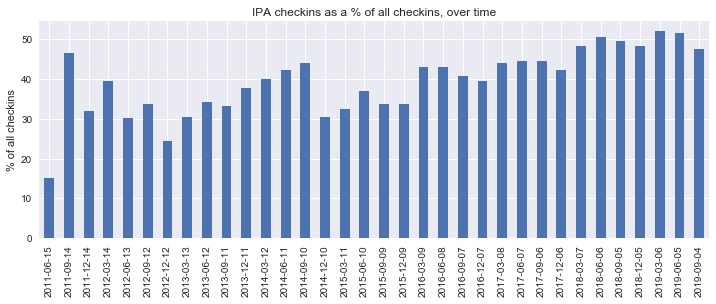

In [293]:
# Those first few quarters consist of too small a number of checkins to
## rightfully include in the following graph, but in the interest of
### keeping the dimensions similar to the previous chart, they're included.
ipa_pct.pct.plot(kind='bar', figsize=(12,4));
plt.ylabel('% of all checkins');
plt.title('IPA checkins as a % of all checkins, over time');

#### While that chart does seem to show how the popularity of IPA's is progressing over time, it should be noted that this group of 8K users was selected by who had checked in the most on a random sample of IPA's, where the IPA's were likely skewed toward recent releases.  Nevertheless, an occasional reader of beer industry headlines knows that IPA sales growth is outpacing other styles in recent years, and this chart is probably an accurate reflection of that.

Before we get into the ratings, let's take a quick look at a few more dataframe columns, starting with the distribution of abv (alcohol by volume) in these beers.

In [265]:
print(f'Number of beers with no given abv: {len(df[df.abv==0])}')
print(f'Max abv listed:  {max(df.abv)}')

Number of beers with no given abv: 15790
Max abv listed:  80.0


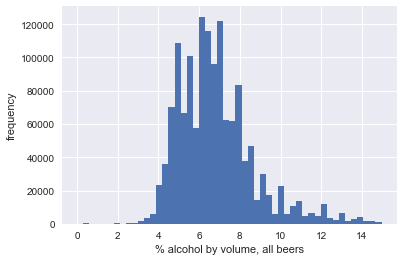

In [266]:
# Remove those outliers (abv = 80% ??) to make the histogram more accurate
_ = plt.hist(df.abv[(df.abv > 0) & (df.abv < 15)], bins=50)
_ = plt.xlabel('% alcohol by volume, all beers')
_ = plt.ylabel('frequency')
plt.show()

Break apart the above chart to compare the alcohol levels of IPA's vs other beers.

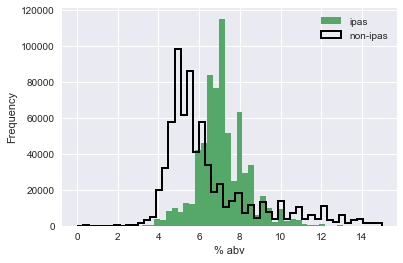

In [267]:
ipas[(ipas.abv > 0) & (ipas.abv < 15)].abv.plot(kind='hist', color='C1',
                                                label='ipas', bins=50)
non_ipas[(non_ipas.abv > 0) & (non_ipas.abv < 15)].abv.plot(kind='hist', color='k', lw=2,
                                                            histtype='step', label='non-ipas', bins=50)
plt.xlabel('% abv')
plt.legend()
plt.show()

In [269]:
print(f'The mean abv for an IPA in this dataset is {round(np.mean(ipas.abv), 3)} %')
print(f'For other beers in this dataset, the mean abv is {round(np.mean(non_ipas.abv), 3)} %')
print()
print(f'The abv standard deviation for an IPA in this dataset is {round(np.std(ipas.abv), 3)}')
print(f'For other beers in this dataset, the abv std is {round(np.std(non_ipas.abv), 3)}')

The mean abv for an IPA in this dataset is 7.112 %
For other beers in this dataset, the mean abv is 6.447 %

The abv standard deviation for an IPA in this dataset is 1.417
For other beers in this dataset, the abv std is 2.639


#### The mean abv for IPA's is higher, but the non-IPA's are spread out more and cover the extremes in both directions.  Their spread is  a consequence of their encompassing more styles.

Finally, what sorts of breweries make these checked in beers, and what sort of venues are people checking in from?

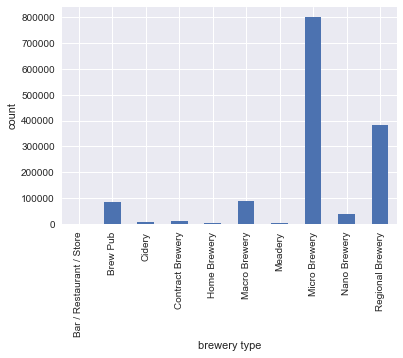

In [271]:
df.groupby('brewery_type').size().plot(kind='bar')
plt.ylabel('count')
plt.xlabel('brewery type')
plt.show()

#### Over half of the 1.4 mil checkins are for microbrews, so it's clear that the people using Untappd's app are not interested in rating and sharing with the world their consumption of macrobrews, which in reality make up the vast majority of beer sales in the U.S. and the rest of the world.

The checkins have features `venue_cat` and `venue_type`, so let's see which is more useful:

In [301]:
print(list(zip(df.venue_cat.iloc[:10], df.venue_type.iloc[:10])))

[(nan, '[]'), ('Nightlife Spot', "['brewery']"), ('Nightlife Spot', "['brewery']"), (nan, '[]'), (nan, '[]'), (nan, '[]'), ('Food', "['steakhouse']"), (nan, '[]'), (nan, '[]'), (nan, '[]')]


`venue_type` has more descriptive info ('brewery' as opposed to 'Nightlife Spot', and 'steakhouse' vs. 'Food'), and also has lists for multiple venue types in some cases, so we'll use `venue_type`.

In [314]:
print(f'Number of checkins with venues specified: {sum(1 for row in df.venue_type if row)}')

Number of checkins with venues specified: 1425447


That is all the checkins, which means that when saving and loading this dataset, pandas has converted empty lists into string representations of an empty list, which then doesn't evaluate to False.  Need to convert back to actual lists.

In [315]:
import ast  # to 'unstring' the venue lists
df.venue_type = [ast.literal_eval(venuelist) for venuelist in df.venue_type]
print(f'Number of checkins with venues specified: {sum(1 for row in df.venue_type if row)}')

Number of checkins with venues specified: 1001743


How many different venue types?

In [318]:
places = [place for row in df.venue_type for place in row]

len(set(places))

773

In [322]:
# That's a lot of types.  What are the common ones
from collections import Counter
placeCounter = Counter(places)
placeCounter.most_common(10)

[('brewery', 348535),
 ('bar', 153148),
 ('beer_bar', 118502),
 ('american_restaurant', 88976),
 ('pub', 73977),
 ('beer_garden', 68234),
 ('restaurant', 45211),
 ('gastropub', 42665),
 ('beer_store', 39389),
 ('pizza_place', 34767)]

To be able to read a plot of (str, float) pairs like the above, 
it'll be easier to make a function that stacks the strings vertically
along the y-axis and plots the floats as x-values.

In [573]:
def plot_str_keys(str_keyed_tuplist, xlab='', ylab='', title=''):
    '''Take a list of (keyword, value) pairs.
    Sort them by highest values.
    Plot them with the keyword on the y-axis
    and value on x-axis, for easier reading.
    '''
    words, vals = zip(*sorted(str_keyed_tuplist, key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(8, len(words) // 2))
    plt.plot(vals, range(len(words), 0, -1))
    plt.yticks(range(len(words), 0, -1), words)
    
    if xlab:
        plt.xlabel(xlab)
    if ylab:
        plt.ylabel(ylab)
    if title:
        plt.title(title)
    
    plt.show()

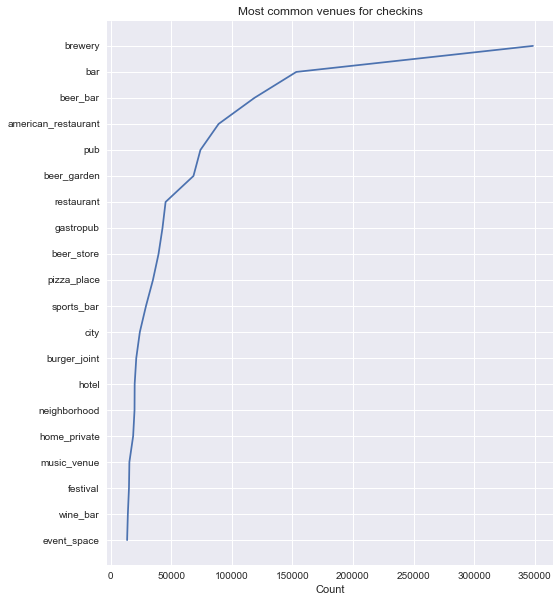

In [574]:
x = 'Count'
t = 'Most common venues for checkins'
plot_str_keys(placeCounter.most_common(20), xlab=x, title=t)

In [345]:
# just curious what a few of the least common venue types are
placeCounter.most_common()[-10:]

[('motorsports_shop', 1),
 ('pelmeni_house', 1),
 ('blini_house', 1),
 ('nutritionist', 1),
 ('law_school', 1),
 ('tempura_restaurant', 1),
 ('sukiyaki_restaurant', 1),
 ('concert_halls', 1),
 ('child_care_service', 1),
 ('campanian_restaurant', 1)]

#### It's reaffirming to know that people are comfortable sharing their drinking locations with the world when they are at breweries and bars much moreso than when they are at nutritionists or childcare services.


======================================================================================================================


## In this second part of the notebook we'll take a look at how ratings are distributed and how they relate to other features.

First off, there are 2 ratings columns in this dataset, one for the user who checked in ('rating_user') and another for the mean of all user ratings ever ('rating_global') for the beer.

For the most part, users can rate a beer in any 0.25 increment up to 5.00, although there are some ratings in increments of 0.10, which come from users that have paid Untappd for some sort of Premium level of the app (which is free otherwise).  I removed all the 0.00 ratings from the data, on the assumption that they are much more likely to reflect "No Rating" than "The Worst Beer Ever," and though the app defaults to 0.00 on its rating slider, it states to the user that the rating is "No Rating."  A quick look at the ratings distribution, with its scarcity of 0.25-1.75 ratings, supports this approach:  

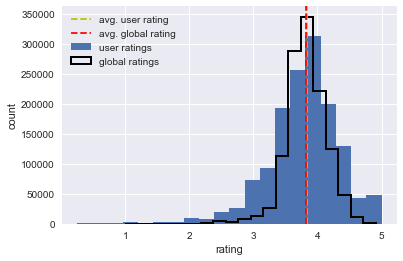

In [285]:
plt.hist(df.rating_user, bins=20, label='user ratings')
plt.hist(df[df.rating_global > 0].rating_global, histtype='step',
         color='k', bins=20, label='global ratings', lw=2)
plt.xlabel('rating')
plt.ylabel('count')
plt.axvline(x=df.rating_user.mean(), color='y', linestyle='--',
            label='avg. user rating')
plt.axvline(x=df[df.rating_global > 0].rating_global.mean(), linestyle='--',
            label='avg. global rating', color='r')
plt.legend();

#### Globally, almost all ratings averages have settled into the 3.25 - 4.5 range over time, while the local user ratings are more spread out, having so many fewer ratings per beer.

In [352]:
print(f'std of user ratings:    {np.round(df.rating_user.std(), 3)}')
print(f'std of global ratings:  {np.round(df.rating_global.std(), 3)}')

std of user ratings:    0.6
std of global ratings:  0.362


Break down the blue part of the above graph into user ratings for IPA vs non_IPA

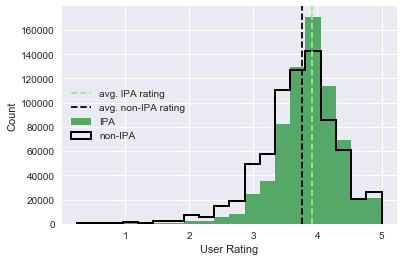

In [290]:
plt.hist(ipas.rating_user, bins=20, color='C1', label='IPA')
plt.hist(non_ipas.rating_user, bins=20, histtype='step', lw=2, label='non-IPA', color='k')
plt.xlabel('User Rating')
plt.ylabel('Count')
plt.axvline(x=ipas.rating_user.mean(), color='lightgreen', linestyle='--',
            label='avg. IPA rating')
plt.axvline(x=non_ipas.rating_user.mean(), color='k', linestyle='--',
            label='avg. non-IPA rating')
plt.legend(loc='center left');

#### The IPA's are packed pretty closely around 4-star ratings, while the non-IPA's spread out more below 4 stars and also represent more of the 5-star ratings.

In [351]:
print(f'std of user IPA ratings:     {np.round(ipas.rating_user.std(), 3)}')
print(f'std of user non-IPA ratings: {np.round(non_ipas.rating_user.std(), 3)}')

std of user IPA ratings:     0.522
std of user non-IPA ratings: 0.654


A few bar charts to compare the same user/global and IPA/non-IPA splits and their means:

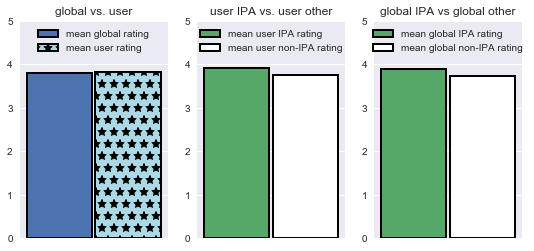

In [346]:
plt.figure(figsize=(9,4))

plt.subplot(131)
plt.bar(1, df.rating_global.mean(), width=1.9, label='mean global rating', linewidth=2, edgecolor='k')
plt.bar(3, df.rating_user.mean(), width=1.9, label='mean user rating', 
        color='lightblue', linewidth=2, edgecolor='k', hatch='*')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('global vs. user');

plt.subplot(132)
plt.bar(1, ipas.rating_user.mean(), width=1.9, label='mean user IPA rating', 
        color='C1', linewidth=2, edgecolor='k')
plt.bar(3, non_ipas.rating_user.mean(), width=1.9, label='mean user non-IPA rating',
       color='w', linewidth=2, edgecolor='k')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('user IPA vs. user other');

plt.subplot(133)
plt.bar(1, ipas.rating_global.mean(), width=1.9, label='mean global IPA rating', 
        color='C1', linewidth=2, edgecolor='k')
plt.bar(3, non_ipas.rating_global.mean(), width=1.9, label='mean global non-IPA rating',
       color='w', linewidth=2, edgecolor='k')
plt.legend(loc='upper center')
plt.ylim([0,5])
plt.xticks([])
plt.title('global IPA vs global other');

#### This group of users is slightly more generous than the rest of the world in terms of its mean rating for these beers.
#### It is more noticeably generous towards IPA's than towards other beers in its ratings, as is the rest of the world.

Having seen that this group of 8K users rates beers similarly to the overall user base, on average, we can perhaps have more confidence that any conclusions drawn from analyzing their checkins will generalize to predictions for unseen users. 

In order to find features of these 1.4 million checkins which most strongly serve to predict their ratings, let's begin with several likely candidates:  
 - <font color=blue>Brewery:</font>  ` `Naturally, certain breweries make superior products.
     - <font color=blue>Brewery Type:</font>    ` `Possibly a useful predictor.
 - <font color=blue>Beer:</font>  ` `  Certainly a beer's rating history should correlate strongly with its future ratings.
     - <font color=blue>Beer Type:</font>    ` `Probably a useful predictor.
     - <font color=blue>Beer Description:</font>   ` ` Certain words (e.g. ingredients) are probably good predictors.
 - <font color=blue>User:</font>   ` ` Some users simply rate beers higher in general than do others.
 - <font color=blue>Venue:</font>  ` ` Some places store and serve their beers better, or pay more for fresher beers from distributors.
     - <font color=blue>Venue Type:</font>  ` ` Probably a useful predictor.
 - <font color=blue>Distance from Brewery to Venue:</font>   ` ` Especially true for IPA's, many beers taste better fresh.  Although these checkins unfortunately don't include any info about how old the beer is, maybe distance can be used as a proxy.  Perhaps more importantly, people may tend to rate local beers higher.
 - <font color=blue>Alcohol (abv):</font> ` ` Aside from, or maybe because of, its effect on the user, it may have an effect on the rating.


Ratings by brewery

In [438]:
# Group the checkins by brewery to compare ratings
breweries = df.groupby(['brewery_id', 'brewery_name'])

user_mean = breweries.rating_user.mean()
user_counts = breweries.rating_user.size()

global_mean = breweries.rating_global.mean()

brewers = pd.concat([user_mean, user_counts, global_mean], axis=1)
brewers.columns = ['user_mean', 'user_counts', 'global_mean']
brewers.sort_values('user_mean', ascending=False, inplace=True)
brewers.head(10)

,,user_mean,user_counts,global_mean
brewery_id,brewery_name,,,
185694,Lazy Bulldog Brewing,5.0,1,NaN
404322,Black Shoe Brewing Company,5.0,1,NaN
396792,tingel tangel BEER,5.0,1,NaN
370453,Jrg Brewing Co,5.0,1,NaN
42925,Blue Lobster Brewing Company,5.0,1,NaN
14467,Klosterbrauerei Kreuzberg,5.0,2,NaN
165378,Thomas James Brewery,5.0,3,NaN
403846,B2 (Be Squared) Home Brewery,5.0,1,NaN
442245,Waymores Brew Homebrew Greenville NC,5.0,3,NaN


To deal with these one-offs/homebrews that won't lend us any predictive power right now (although we'll inspect homebrews as a brewery style later), we'll need to set some sort of lower threshold on ratings count.

In [419]:
brewers[brewers.user_counts > 100].head(10)

,,user_mean,user_counts,global_mean
brewery_id,brewery_name,,,
371541,Steady Brew Beer Co,4.702439,205,3.301917
276048,Tornion Panimo,4.698347,121,3.039780
266944,Pips Meadery,4.659091,121,4.657363
263,Brouwerij De Sint-Sixtusabdij van Westvleteren,4.565868,167,4.440252
75584,Schramm's Mead,4.523482,247,4.560073
187804,Garagiste Meadery,4.439252,214,4.451774
202,Brasserie Cantillon,4.417051,1170,4.351745
3562,Brouwerij 3 Fonteinen,4.412938,742,4.348489
1244,The Alchemist,4.409142,2390,4.374058


The above table shows the top 10 rated breweries with more than 100 checkins from the 8K users comprising our dataset.  The middle 6 breweries make beers or meads that are very far from the IPA style, so we'll re-focus the analysis to IPA brewers in a moment, but before we do, let's see what's behind the vast difference between user ratings and global ratings for the first two entries, in case it raises any warning flags to be aware of during the rest of this analysis. 

Steady Brew Beer Co is in Southern California, and Tornion Panimo is in Finland.  Does our set of 8K users maybe include people who work for those breweries, or who are somehow connected to them?  Let's see if the checkin venue locations offer any clues, or if the `user_counts` are limited to just a few people for those.

In [428]:
top2 = df[(df.brewery_id == 371541) | (df.brewery_id == 276048)]

# how many users author those 326 checkins? 
top_users = top2.user_id.nunique()

# how many venues host these checkins?
top_spots = top2.venue_id.nunique()

print(f'There were {top_users} unique raters for the {len(top2)} ratings of the top 2 breweries.')
print(f'Out of {top2.venue_id.count()} checkins that listed venues for these top 2, {top_spots} were unique.')

There were 29 unique raters for the 326 ratings of the top 2 breweries.
Out of 318 checkins that listed venues for these top 2, 33 were unique.


Those figures seem reasonable enough not to raise any warning flags, but what if the ratings of the 29 unique raters  are distributed almost completely to 2 people (one for each brewery)?

In [437]:
top2.user_id.value_counts()[:5]

554660     171
3561326    100
2589353      6
911110       5
771066       4
Name: user_id, dtype: int64

That's all you need to see to know that 100 of the 121 Finnish ratings come from one person and 171 of the 205 SoCal ratings come from another.  Not that one person's ratings should count less than another's, but for the purposes of predicting other people's future ratings of beers from these 2 breweries, it won't help to have 2 people skewing the results so far from the global mean.  In other words, the fewer checkins we have for a brewery (or a venue, style, etc.) in our subset of the global data, the more we should rely on the global mean, in order to more accurately generalize our future predictions.  Most data were fetched using 200 checkins per user as a query parameter, so analysis of any category that has beers as a subcategory and uses a threshold of less than a few hundred will be more susceptible to this type of skew.

Now back to the task of seeing how IPA brewers stack up:

In [440]:
# Group the checkins by ipa brewery to compare ratings
breweries = ipas.groupby(['brewery_id', 'brewery_name'])

user_mean = breweries.rating_user.mean()
user_counts = breweries.rating_user.size()

global_mean = breweries.rating_global.mean()

brewers = pd.concat([user_mean, user_counts, global_mean], axis=1)
brewers.columns = ['user_mean', 'user_counts', 'global_mean']
brewers.sort_values('user_mean', ascending=False, inplace=True)
brewers[brewers.user_counts > 100].head(10)

,,user_mean,user_counts,global_mean
brewery_id,brewery_name,,,
1244,The Alchemist,4.456826,2095,4.420380
20084,Tree House Brewing Company,4.440890,10203,4.420001
66854,BNS Brewing & Distilling Co,4.436000,125,3.781970
5143,Russian River Brewing Company,4.410556,2880,4.307847
227413,Root + Branch Brewing,4.399786,234,4.345888
2562,Hill Farmstead Brewery,4.390883,1574,4.373024
21152,Monkish Brewing Co.,4.382240,1616,4.363865
125554,Electric Brewing Company,4.333333,333,4.312904
194091,New Park Brewing,4.314205,176,4.259593


Sniff around that 3rd row, with the wide gap between local and global ratings, and only 125 locals:

In [446]:
df[df.brewery_id == 66854].user_id.value_counts()[:5]

936888     82
1061542    11
3023593     7
114390      7
85776       5
Name: user_id, dtype: int64

That's less obvious than the Finnish and SoCal breweries, but let's compare it to the 9th row here (New Park Brewing), which has similarly few user ratings (176) but has a global mean close to the user mean.

In [444]:
df[df.brewery_id == 194091].user_id.value_counts()[:5]

3195420    21
1565803    15
1951532    12
159159     10
587494      9
Name: user_id, dtype: int64

Less bias there.

Just curious what the tail end of this table looks like:

In [447]:
brewers[brewers.user_counts > 100].tail(10)

,,user_mean,user_counts,global_mean
brewery_id,brewery_name,,,
67113,D9 Brewing Company,3.550350,286,3.576041
1815,Peak Organic Brewing Company,3.540000,275,3.593918
812,Magic Hat Brewing Company,3.515795,459,3.500836
535,Florida Beer Company,3.492611,203,3.567740
403227,Unveiled Brewing Co,3.449541,218,3.478273
1673,Innis & Gunn,3.448558,104,3.417077
1179,Spoetzl Brewery,3.365254,354,3.367627
96120,3 Daughters Brewing,3.353070,114,3.379187
10375,Kirkland Signature,3.350000,115,3.141729


Not horrible ratings there, although the last one suffers quite a dropoff.  The `user_counts` are all pretty low, so it suggests either that people aren't interested in sharing their bad beer experiences or maybe they've just gotten good at avoiding ordering bad beers (by first looking at beer ratings, perhaps?).

That last point suggests the other way of going about this analysis.  Rather than sorting by best ratings, and then choosing a threshold below which to ignore, we could start by looking at the most popular $X$ beers/breweries/states/etc. by checkin counts, and then sort them by highest ratings.  This seems especially efficient if more people have checked in on the better beers, and if we're worried about small sample sizes creating large biases.

Make a function to help with this style of analysis, and try it out on IPA brewers.

In [461]:
def topXratings(df, feat, x=60, xlab='', ylab='', title=''):
    '''Let the user choose a df, an input feature, 
    and an appropriate count threshold for it,
    and plot the sorted ratings.
    '''
    temp = df.set_index(feat)
    freqs = df.groupby(feat).size().sort_values(ascending=False)
    topX = freqs[:x].index.values
    means = temp.loc[topX].groupby(feat)['rating_user'].mean()
    plot_str_keys(means.iteritems(), xlab=xlab, ylab=ylab, title=title)

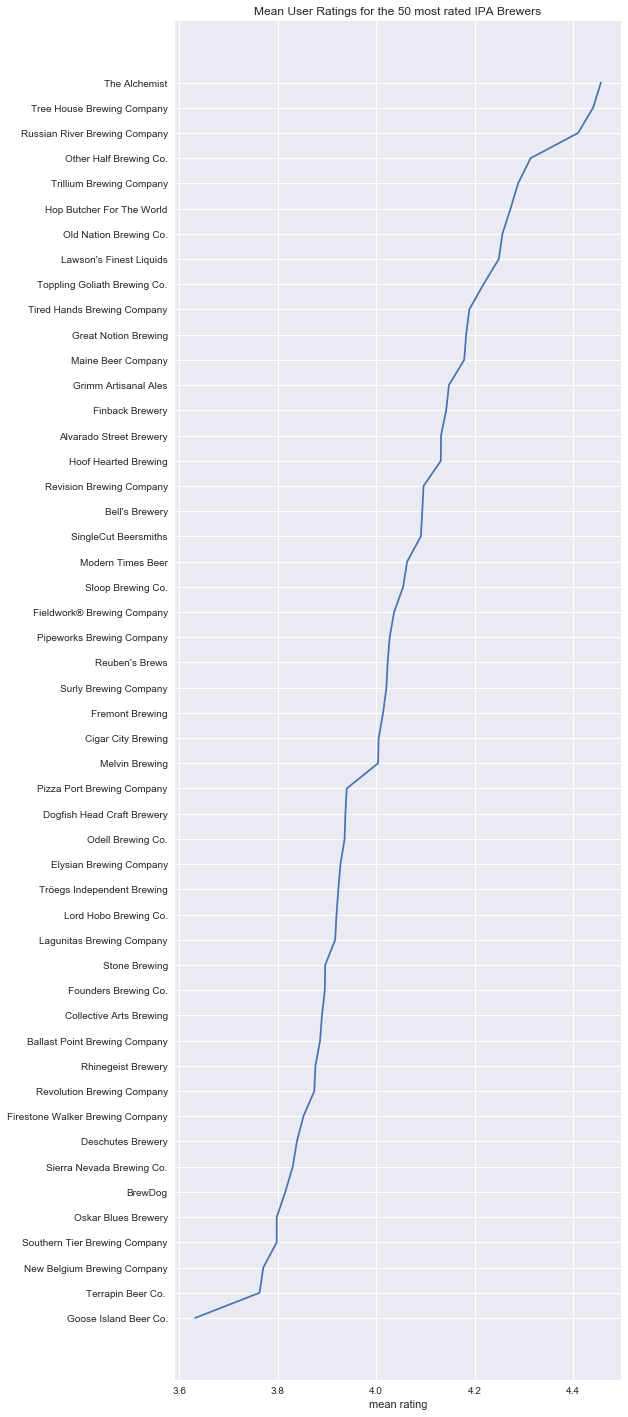

In [575]:
topXratings(ipas, 'brewery_name', x=50, xlab='mean rating', title='Mean User Ratings for the 50 most rated IPA Brewers')

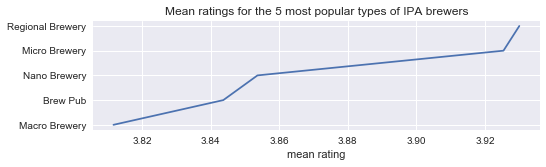

In [576]:
topXratings(ipas, 'brewery_type', x=5, xlab='mean rating', title='Mean ratings for the 5 most popular types of IPA brewers')

That's not much of a spread there, between the first and fifth ranked.  
Let's move on to which beers are ranked highest, again using the 'topX' approach.

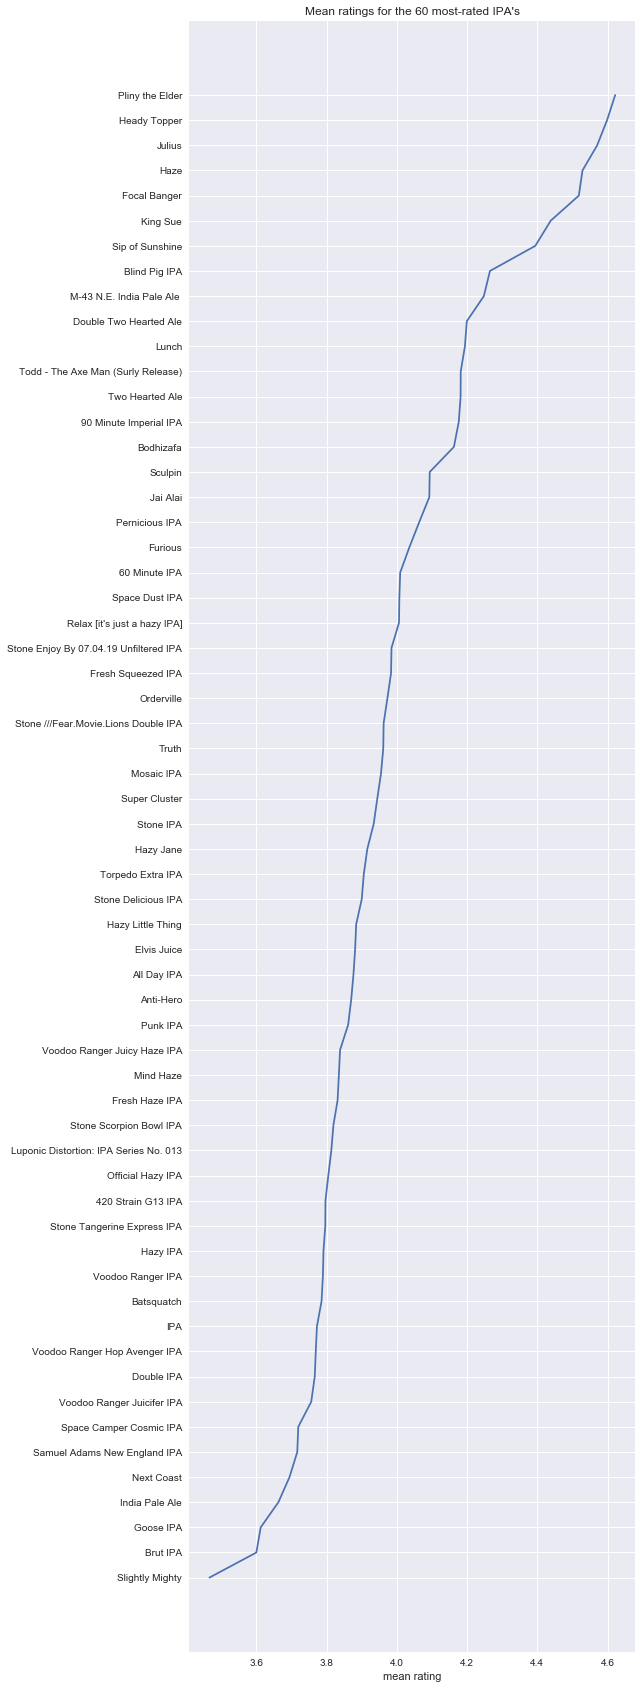

In [577]:
topXratings(ipas, 'beer_name', x=60, xlab='mean rating', title="Mean ratings for the 60 most-rated IPA's")

In [422]:
print(f'Out of the {len(brewers)} breweries in this dataset, {sum(brewers.user_counts > 100)} of them have more than 100 checkins')

Out of the 19553 breweries in this dataset, 2345 of them have more than 100 checkins
